# 🏗️ Synthetic Data Generation

The first dataset generated uses 3D models of drones (object) placed into a real background image (canvas).

Number of images:
- `Training = 20264 / 4 = 5066`
- `Validation = 4304 / 4 = 1076`

Test data will reuse the original data set for comparison.

In [28]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

from src import utils

## 1. Canvas Images

Select a set of canvas images to use for training and validation sets.

In [3]:
# Get the list of images
canvas_imgs = utils.files.get_image_files(os.path.join(utils.EXTERNAL_DATA_DIR, "canvas"))
print(f"There are {len(canvas_imgs)} images.")

There are 77 images.


In [4]:
# Split the images into 80%/20% training/validation
trn_amount = int(0.8 * 77)

trn_canvases = np.random.choice(canvas_imgs, size=trn_amount, replace=False)

val_canvases = [canvas for canvas in canvas_imgs if canvas not in trn_canvases]

print(f"{len(trn_canvases)} training image canvases and {len(val_canvases)} validation image canvases.")

61 training image canvases and 16 validation image canvases.


In [5]:
# Save the lists for later use
trn_canvases = pd.Series(trn_canvases)
val_canvases = pd.Series(val_canvases)

trn_canvases.to_csv(os.path.join(utils.EXTERNAL_DATA_DIR, "canvas", "trn_cache.csv"), index=False)
val_canvases.to_csv(os.path.join(utils.EXTERNAL_DATA_DIR, "canvas", "val_cache.csv"), index=False)

In [2]:
# Read the lists back in
trn_canvases = pd.read_csv(os.path.join(utils.EXTERNAL_DATA_DIR, "canvas", "trn_cache.csv"))
val_canvases = pd.read_csv(os.path.join(utils.EXTERNAL_DATA_DIR, "canvas", "val_cache.csv"))

print(f"{len(trn_canvases)} training image canvases and {len(val_canvases)} validation image canvases.")

61 training image canvases and 16 validation image canvases.


## 2. Objects

Select the objects to use for the images.

In [3]:
# Get the list of 3D model files
model_paths = utils.files.get_3d_model_files(os.path.join(utils.EXTERNAL_DATA_DIR, "3d_models"))

In [4]:
# Load each of the model files into memory as a vtk object
models_list = []
for path in model_paths:
    name = os.path.splitext(os.path.basename(path))[0]
    model = utils.synth.load_3d_model(path)
    models_list.append((name, model))

Objects will be further manipulated at a later stage as they are placed onto the canvas.

## 3. Data Generation

Generate data for the training and validation sets.

### a. Training Data

Create a synthetic data set for training images. The number of images is before the multi-scale splitting that was performed where the images were split into 4 pieces. After generation the images will be cut in the same way to make them similar to the original baseline data.

In [15]:
# Set the number of training data images to create
training_total = 5066  # Actual = 5066

In [16]:
# Set the data directory
train_data_dir = os.path.join(utils.INTERIM_DATA_DIR, "3d_model_data", "train")

# Create the folders if they don't exist
os.makedirs(train_data_dir, exist_ok=True)

In [17]:
# Set a random number generator seed for reproducibility
rng = np.random.default_rng(seed=42)

# Loop to create training data equal to the total number specified
for i in range(training_total):
    
    # Create a base file name for the final image and annotation file
    base_filename = f"3d_model_img_{i:05d}"
    
    if i % 100 == 0:
        print(f"Creating training image {i} of {training_total}")

    # Randomly select a canvas image
    canvas_path = rng.choice(trn_canvases)[0]
    canvas = Image.open(canvas_path)
    canvas_size = canvas.size

    # Select a random number of models to place in the canvas
    num_models = rng.integers(low=1, high=6)

    # Loop for each model to be placed
    for m in range(num_models):
        # Randomly select a 3D model file
        name, model = rng.choice(models_list)
        
        # Handle models with specific initial orientations
        if "shahed" in name:
            # Set initial orientation
            init_pitch = -90
            init_yaw = 0
            init_roll = -90
            
        elif "dji_m600" in name:
            # Set initial orientation
            init_pitch = 0
            init_yaw = 0
            init_roll = 0
            
        else:
            # Set initial (default) orientation
            init_pitch = 0
            init_yaw = -90
            init_roll = 0
            
        # Set a seed for the model randomization
        model_seed = (i + 1) * 10 + (m + 1)
        
        # Orient the model randomly
        model = utils.synth.camera_view(model, init_pitch=init_pitch, init_yaw=init_yaw, init_roll=init_roll, randomize=True, seed=model_seed)
        model_img = utils.synth.vtk_to_PIL(model)
        
        # Scale the object to a random size
        # Scale is a factor of the canvas size
        scale_factor = utils.synth.rng_scale(seed=model_seed)
        model_img = utils.synth.scale_obj(model_img, scale_factor, canvas_size)
        # Width and height ratios for annotation
        obj_width = model_img.size[0] / canvas_size[0]
        obj_height = model_img.size[1] / canvas_size[1]
        
        # Randomly position the object within the canvas
        coordinates_topleft = utils.synth.rng_position(model_img.size, canvas_size, seed=model_seed)
        # Calculate the center coordinates for annotation
        x_center = (coordinates_topleft[0] + model_img.size[0] / 2) / canvas_size[0]
        y_center = (coordinates_topleft[1] + model_img.size[1] / 2) / canvas_size[1]
        
        # Paste the object onto the canvas
        canvas.paste(model_img, coordinates_topleft, model_img)
        
        # Add the annotation for the object to the annotation text file
        ann = [0, x_center, y_center, obj_width, obj_height]  # Class is 0 since all objects are the same class
        with open(os.path.join(train_data_dir, f"{base_filename}.txt"), "a") as ann_file:
            ann_file.write(" ".join([str(a) for a in ann]) + "\n")
            
    # Save the final image
    canvas.save(os.path.join(train_data_dir, f"{base_filename}.png"))

Creating training image 0 of 5066
Creating training image 100 of 5066
Creating training image 200 of 5066
Creating training image 300 of 5066
Creating training image 400 of 5066
Creating training image 500 of 5066
Creating training image 600 of 5066
Creating training image 700 of 5066
Creating training image 800 of 5066
Creating training image 900 of 5066
Creating training image 1000 of 5066
Creating training image 1100 of 5066
Creating training image 1200 of 5066
Creating training image 1300 of 5066
Creating training image 1400 of 5066
Creating training image 1500 of 5066
Creating training image 1600 of 5066
Creating training image 1700 of 5066
Creating training image 1800 of 5066
Creating training image 1900 of 5066
Creating training image 2000 of 5066
Creating training image 2100 of 5066
Creating training image 2200 of 5066
Creating training image 2300 of 5066
Creating training image 2400 of 5066
Creating training image 2500 of 5066
Creating training image 2600 of 5066
Creating trai

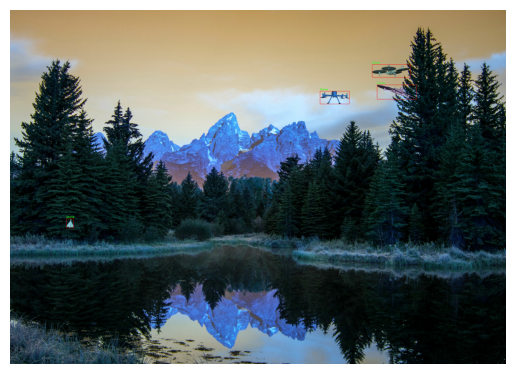

In [18]:
# Check bounding boxes
trn_imgs = utils.files.get_image_files(train_data_dir)
ann_files = utils.files.get_annotation_files(train_data_dir)

random_img = rng.integers(low=0, high=len(trn_imgs))
trn_img = trn_imgs[random_img]
ann_file = ann_files[random_img]

bboxes = utils.label_data.read_bbox_file(ann_file)

xxyy_bboxes = []
for bbox in bboxes:
    xxyy_bbox = utils.label_data.bbox_xxyy(bbox)
    xxyy_bboxes.append(xxyy_bbox)

bbox_img = utils.image_data.draw_bbox(trn_img, xxyy_bboxes)

plt.imshow(bbox_img)
plt.axis('off')
plt.show()

Split the images into four overlapping quadrants to minimize scaling of small objects in the images.

In [24]:
# Multiscale data destination directory
multiscale_data_dir = os.path.join(utils.INTERIM_DATA_DIR, "3d_model_data", "multiscale")
os.makedirs(multiscale_data_dir, exist_ok=True)

In [25]:
# Create the training data directory
ms_train_data_dir = os.path.join(multiscale_data_dir, "train")
os.makedirs(ms_train_data_dir, exist_ok=True)

In [26]:
# Get the list of images and annotations in the training data directory
train_images = utils.files.get_image_files(train_data_dir)
train_annotations = utils.files.get_annotation_files(train_data_dir)
print("There are {} training images and {} training annotations.".format(len(train_images), len(train_annotations)))

There are 5066 training images and 5066 training annotations.


In [27]:
# Ensure all file names match in order
for img, ann in zip(train_images, train_annotations):
    img_base = os.path.splitext(os.path.basename(img))[0]
    ann_base = os.path.splitext(os.path.basename(ann))[0]
    if img_base != ann_base:
        print(f"Mismatch found: Image {img_base} and Annotation {ann_base}")
        # Check if the annotation file exists
        if not os.path.exists(ann):
            print(f"Annotation file {ann} does not exist.")
        else:
            print(f"Annotation file {ann} exists.")
        break
print("No mismatches found between training images and annotations.")

No mismatches found between training images and annotations.


In [29]:
# Create a dictionary for quadrant aliases for final file names
quadrant_alias = {
    "top_left": "00",
    "top_right": "01",
    "bottom_left": "10",
    "bottom_right": "11"
}

In [30]:
# Split the training images and annotations into 4 quadrants with a 5% overlap

for img, ann in zip(train_images, train_annotations):
    # Get the base file name without extension for final file names
    base_name = os.path.splitext(os.path.basename(img))[0]

    # Read the image
    image = cv2.imread(img)
    if image is None:
        print(f"Failed to read image {img}")
        continue
    # Get the base image dimensions
    base_height = image.shape[0]
    base_width = image.shape[1]

    # If the image dimensions are below a threshold, skip it
    if base_height < 800 and base_width < 800:
        print(f"Image {img} is too small ({base_width}x{base_height}), skipping.")
        continue

    # Split the image into 4 quadrants
    img_quadrants = utils.image_data.image_quadrants(img)
    
    # Split the annotation into 4 quadrants
    ann_bboxes = utils.label_data.read_bbox_file(ann)
    ann_quadrants = utils.label_data.bbox_quadrants(ann_bboxes)

    # Process each quadrant
    for quad_name, img_quad in img_quadrants.items():
        ann_quad = ann_quadrants.get(quad_name, [])
        # Save the quadrant image and its annotations
        cv2.imwrite(os.path.join(ms_train_data_dir, f"{base_name}_{quadrant_alias[quad_name]}.png"), img_quad)
        with open(os.path.join(ms_train_data_dir, f"{base_name}_{quadrant_alias[quad_name]}.txt"), 'w') as f:
            for bbox in ann_quad:
                obj, x_c, y_c, w, h = utils.label_data.bbox_yolo(bbox)
                line = f"{obj} {x_c} {y_c} {w} {h}\n"
                f.write(line)

### b. Validation Data

In [19]:
# Set the number of validation data images to create
validation_total = 1076  # Actual = 1076

In [20]:
# Set the data directory
val_data_dir = os.path.join(utils.INTERIM_DATA_DIR, "3d_model_data", "val")

# Create the folders if they don't exist
os.makedirs(val_data_dir, exist_ok=True)

In [21]:
# Set a random number generator seed for reproducibility
rng = np.random.default_rng(seed=12345)

# Loop to create training data equal to the total number specified
for i in range(validation_total):
    
    # Create a base file name for the final image and annotation file
    base_filename = f"3d_model_img_v_{i:05d}"
    
    if i % 100 == 0:
        print(f"Creating validation image {i} of {validation_total}")

    # Randomly select a canvas image
    canvas_path = rng.choice(val_canvases)[0]
    canvas = Image.open(canvas_path)
    canvas_size = canvas.size

    # Select a random number of models to place in the canvas
    num_models = rng.integers(low=1, high=6)

    # Loop for each model to be placed
    for m in range(num_models):
        # Randomly select a 3D model file
        name, model = rng.choice(models_list)
        
        # Handle models with specific initial orientations
        if "shahed" in name:
            # Set initial orientation
            init_pitch = -90
            init_yaw = 0
            init_roll = -90
            
        elif "dji_m600" in name:
            # Set initial orientation
            init_pitch = 0
            init_yaw = 0
            init_roll = 0
            
        else:
            # Set initial (default) orientation
            init_pitch = 0
            init_yaw = -90
            init_roll = 0
            
        # Set a seed for the model randomization
        model_seed = (i + 1) * 100 + (m + 1)
        
        # Orient the model randomly
        model = utils.synth.camera_view(model, init_pitch=init_pitch, init_yaw=init_yaw, init_roll=init_roll, randomize=True, seed=model_seed)
        model_img = utils.synth.vtk_to_PIL(model)
        
        # Scale the object to a random size
        # Scale is a factor of the canvas size
        scale_factor = utils.synth.rng_scale(seed=model_seed)
        model_img = utils.synth.scale_obj(model_img, scale_factor, canvas_size)
        # Width and height ratios for annotation
        obj_width = model_img.size[0] / canvas_size[0]
        obj_height = model_img.size[1] / canvas_size[1]
        
        # Randomly position the object within the canvas
        coordinates_topleft = utils.synth.rng_position(model_img.size, canvas_size, seed=model_seed)
        # Calculate the center coordinates for annotation
        x_center = (coordinates_topleft[0] + model_img.size[0] / 2) / canvas_size[0]
        y_center = (coordinates_topleft[1] + model_img.size[1] / 2) / canvas_size[1]
        
        # Paste the object onto the canvas
        canvas.paste(model_img, coordinates_topleft, model_img)
        
        # Add the annotation for the object to the annotation text file
        ann = [0, x_center, y_center, obj_width, obj_height]  # Class is 0 since all objects are the same class
        with open(os.path.join(val_data_dir, f"{base_filename}.txt"), "a") as ann_file:
            ann_file.write(" ".join([str(a) for a in ann]) + "\n")
            
    # Save the final image
    canvas.save(os.path.join(val_data_dir, f"{base_filename}.png"))

Creating validation image 0 of 1076
Creating validation image 100 of 1076
Creating validation image 200 of 1076
Creating validation image 300 of 1076
Creating validation image 400 of 1076
Creating validation image 500 of 1076
Creating validation image 600 of 1076
Creating validation image 700 of 1076
Creating validation image 800 of 1076
Creating validation image 900 of 1076
Creating validation image 1000 of 1076


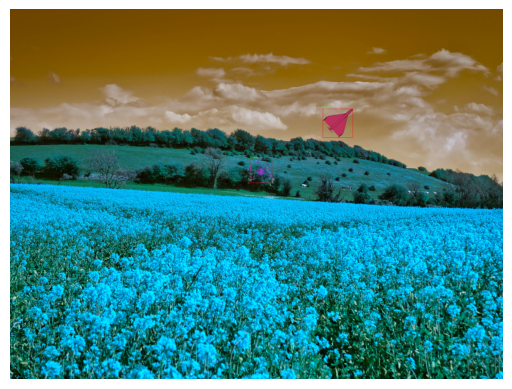

In [23]:
# Check bounding boxes
val_imgs = utils.files.get_image_files(val_data_dir)
ann_val_files = utils.files.get_annotation_files(val_data_dir)

random_img = rng.integers(low=0, high=len(val_imgs))
val_img = val_imgs[random_img]
ann_val_file = ann_val_files[random_img]

bboxes = utils.label_data.read_bbox_file(ann_val_file)

xxyy_bboxes = []
for bbox in bboxes:
    xxyy_bbox = utils.label_data.bbox_xxyy(bbox)
    xxyy_bboxes.append(xxyy_bbox)

bbox_img = utils.image_data.draw_bbox(val_img, xxyy_bboxes)

plt.imshow(bbox_img)
plt.axis('off')
plt.show()

Split the images into four overlapping quadrants to minimize scaling of small objects in images.

In [31]:
# Multiscale data destination directory
multiscale_data_dir = os.path.join(utils.INTERIM_DATA_DIR, "3d_model_data", "multiscale")
os.makedirs(multiscale_data_dir, exist_ok=True)

In [32]:
# Create the validation data directory
ms_val_data_dir = os.path.join(multiscale_data_dir, "val")
os.makedirs(ms_val_data_dir, exist_ok=True)

In [33]:
# Get the list of images and annotations in the validation data directory
val_images = utils.files.get_image_files(val_data_dir)
val_annotations = utils.files.get_annotation_files(val_data_dir)
print("There are {} validation images and {} validation annotations.".format(len(val_images), len(val_annotations)))

There are 1076 validation images and 1076 validation annotations.


In [34]:
# Ensure all file names match in order
for img, ann in zip(val_images, val_annotations):
    img_base = os.path.splitext(os.path.basename(img))[0]
    ann_base = os.path.splitext(os.path.basename(ann))[0]
    if img_base != ann_base:
        print(f"Mismatch found: Image {img_base} and Annotation {ann_base}")
        # Check if the annotation file exists
        if not os.path.exists(ann):
            print(f"Annotation file {ann} does not exist.")
        else:
            print(f"Annotation file {ann} exists.")
        break
print("No mismatches found between validation images and annotations.")

No mismatches found between validation images and annotations.


In [35]:
# Create a dictionary for quadrant aliases for final file names
quadrant_alias = {
    "top_left": "00",
    "top_right": "01",
    "bottom_left": "10",
    "bottom_right": "11"
}

In [36]:
# Split the validation images and annotations into 4 quadrants with a 5% overlap

for img, ann in zip(val_images, val_annotations):
    # Get the base file name without extension for final file names
    base_name = os.path.splitext(os.path.basename(img))[0]

    # Read the image
    image = cv2.imread(img)
    if image is None:
        print(f"Failed to read image {img}")
        continue
    # Get the base image dimensions
    base_height = image.shape[0]
    base_width = image.shape[1]

    # If the image dimensions are below a threshold, skip it
    if base_height < 800 and base_width < 800:
        print(f"Image {img} is too small ({base_width}x{base_height}), skipping.")
        continue

    # Split the image into 4 quadrants
    img_quadrants = utils.image_data.image_quadrants(img)
    
    # Split the annotation into 4 quadrants
    ann_bboxes = utils.label_data.read_bbox_file(ann)
    ann_quadrants = utils.label_data.bbox_quadrants(ann_bboxes)

    # Process each quadrant
    for quad_name, img_quad in img_quadrants.items():
        ann_quad = ann_quadrants.get(quad_name, [])
        # Save the quadrant image and its annotations
        cv2.imwrite(os.path.join(ms_val_data_dir, f"{base_name}_{quadrant_alias[quad_name]}.png"), img_quad)
        with open(os.path.join(ms_val_data_dir, f"{base_name}_{quadrant_alias[quad_name]}.txt"), 'w') as f:
            for bbox in ann_quad:
                obj, x_c, y_c, w, h = utils.label_data.bbox_yolo(bbox)
                line = f"{obj} {x_c} {y_c} {w} {h}\n"
                f.write(line)

## 4. Examples

Save some examples of the training data with annotations.

In [37]:
# Get a list of the image and annotation files
data_directory = os.path.join(utils.PROCESSED_DATA_DIR, "3d_models", "train")
data_images = utils.files.get_image_files(data_directory)
data_annotations = utils.files.get_annotation_files(data_directory)

print(f"There are {len(data_images)} images and {len(data_annotations)} annotation files.")

There are 20264 images and 20264 annotation files.


In [38]:
# Select a series of random indices
rng = np.random.default_rng(seed=1)
random_idx = rng.choice(len(data_images), size=10, replace=False)

print(random_idx)

[ 6318  9584 16673   706 19221 10367  2920 15297 19254  5050]


In [39]:
# Create a directory to hold the example images
examples_dir = os.path.join(utils.PROCESSED_DATA_DIR, "3d_models", "examples")
os.makedirs(examples_dir, exist_ok=True)

In [40]:
# Loop through the indices
for idx in random_idx:
    # Get the image and annotation file paths
    img_path = data_images[idx]
    ann_path = data_annotations[idx]
    
    # Load the bbox data
    bboxes = utils.label_data.read_bbox_file(ann_path)
    
    # Get a list of the converted bounding boxes
    xxyy_bboxes = []
    for bbox in bboxes:
        xxyy_bbox = utils.label_data.bbox_xxyy(bbox)
        xxyy_bboxes.append(xxyy_bbox)
        
    # Draw the bounding boxes on the image
    bbox_img = utils.image_data.draw_bbox(img_path, xxyy_bboxes)
    
    # Save the image to the examples directory
    base_name = f"3d_model_ex_{os.path.basename(img_path)}"
    cv2.imwrite(os.path.join(examples_dir, base_name), bbox_img)

## 5. Segment Data into Discrete Chunks

Blends of the data will be tested at discrete chunks of data of approximately 20% of the whole.

In [41]:
# Total number of images
total_trn = 20264
total_val = 4304

# Fraction of the total for each set
fraction = 0.2

# Calculate the number of images for each fraction
trn_count = int(total_trn * fraction)
trn_mod = total_trn % 5
val_count = int(total_val * fraction)
val_mod = total_val % 5
print(f"Training count: {trn_count}, remainder: {trn_mod}\nValidation count: {val_count}, remainder: {val_mod}")

Training count: 4052, remainder: 4
Validation count: 860, remainder: 4


In [43]:
# Balancing the dataset as closely as possible 
trn_data_splits = [4053, 4053, 4053, 4053, 4052]  # Total = 20264
val_data_splits = [861, 861, 861, 861, 860]  # Total = 4304

# Verify the splits
print(f"Training splits sum to {sum(trn_data_splits)}")
print(f"Validation splits sum to {sum(val_data_splits)}")

Training splits sum to 20264
Validation splits sum to 4304


In [44]:
# Create a pandas DataFrame to hold the splits
trn_data_splits_df = pd.DataFrame(columns=["img_path", "ann_path", "set"])
val_data_splits_df = pd.DataFrame(columns=["img_path", "ann_path", "set"])

In [45]:
# Get lists of the image and annotation files
trn_images = utils.files.get_image_files(os.path.join(utils.PROCESSED_DATA_DIR, "3d_models", "train"))
trn_annotations = utils.files.get_annotation_files(os.path.join(utils.PROCESSED_DATA_DIR, "3d_models", "train"))
val_images = utils.files.get_image_files(os.path.join(utils.PROCESSED_DATA_DIR, "3d_models", "val"))
val_annotations = utils.files.get_annotation_files(os.path.join(utils.PROCESSED_DATA_DIR, "3d_models", "val"))

In [46]:
# Populate the dataframes
trn_data_splits_df["img_path"] = trn_images
trn_data_splits_df["ann_path"] = trn_annotations
val_data_splits_df["img_path"] = val_images
val_data_splits_df["ann_path"] = val_annotations

In [48]:
# Create a list of the indices for each dataframe
trn_idx = trn_data_splits_df.index.to_list()
val_idx = val_data_splits_df.index.to_list()

In [49]:
# Split the index lists into random chunks
rng = np.random.default_rng(seed=111111)
trn_idx_splits = np.array_split(rng.permutation(trn_idx), 5)
val_idx_splits = np.array_split(rng.permutation(val_idx), 5)

In [53]:
# Loop through the permutations and assign the splits to the dataframe
split_id = 1
for i in trn_idx_splits:
    for idx in i:
        trn_data_splits_df.loc[idx, "set"] = split_id
    split_id += 1

trn_data_splits_df["set"] = trn_data_splits_df["set"].astype(int)
trn_data_splits_df

,img_path,ann_path,set
0,data\processed\3d_models\train\3d_model_img_00...,data\processed\3d_models\train\3d_model_img_00...,3
1,data\processed\3d_models\train\3d_model_img_00...,data\processed\3d_models\train\3d_model_img_00...,4
2,data\processed\3d_models\train\3d_model_img_00...,data\processed\3d_models\train\3d_model_img_00...,4
3,data\processed\3d_models\train\3d_model_img_00...,data\processed\3d_models\train\3d_model_img_00...,1
4,data\processed\3d_models\train\3d_model_img_00...,data\processed\3d_models\train\3d_model_img_00...,2
...,...,...,...
20259,data\processed\3d_models\train\3d_model_img_05...,data\processed\3d_models\train\3d_model_img_05...,2
20260,data\processed\3d_models\train\3d_model_img_05...,data\processed\3d_models\train\3d_model_img_05...,2
20261,data\processed\3d_models\train\3d_model_img_05...,data\processed\3d_models\train\3d_model_img_05...,3
20262,data\processed\3d_models\train\3d_model_img_05...,data\processed\3d_models\train\3d_model_img_05...,3


In [54]:
# Loop through the permutations and assign the splits to the dataframe
split_id = 1
for i in val_idx_splits:
    for idx in i:
        val_data_splits_df.loc[idx, "set"] = split_id
    split_id += 1

val_data_splits_df["set"] = val_data_splits_df["set"].astype(int)
val_data_splits_df

,img_path,ann_path,set
0,data\processed\3d_models\val\3d_model_img_v_00...,data\processed\3d_models\val\3d_model_img_v_00...,3
1,data\processed\3d_models\val\3d_model_img_v_00...,data\processed\3d_models\val\3d_model_img_v_00...,2
2,data\processed\3d_models\val\3d_model_img_v_00...,data\processed\3d_models\val\3d_model_img_v_00...,5
3,data\processed\3d_models\val\3d_model_img_v_00...,data\processed\3d_models\val\3d_model_img_v_00...,1
4,data\processed\3d_models\val\3d_model_img_v_00...,data\processed\3d_models\val\3d_model_img_v_00...,5
...,...,...,...
4299,data\processed\3d_models\val\3d_model_img_v_01...,data\processed\3d_models\val\3d_model_img_v_01...,4
4300,data\processed\3d_models\val\3d_model_img_v_01...,data\processed\3d_models\val\3d_model_img_v_01...,2
4301,data\processed\3d_models\val\3d_model_img_v_01...,data\processed\3d_models\val\3d_model_img_v_01...,1
4302,data\processed\3d_models\val\3d_model_img_v_01...,data\processed\3d_models\val\3d_model_img_v_01...,5


In [55]:
# Save the dataframes to CSV files
trn_data_splits_df.to_csv(os.path.join(utils.PROCESSED_DATA_DIR, "3d_models", "train_data_splits.csv"), index=False)
val_data_splits_df.to_csv(os.path.join(utils.PROCESSED_DATA_DIR, "3d_models", "val_data_splits.csv"), index=False)